<a href="https://colab.research.google.com/github/genaiconference/AgenticAI_GenAIHack/blob/main/01_react_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/genaiconference/AgenticAI_GenAIHack.git

In [ ]:
!pip install -r /content/AgenticAI_GenAIHack/requirements_agenti_ai.txt

In [8]:
import warnings
warnings.filterwarnings("ignore")

import functools, operator, requests, os, json
from bs4 import BeautifulSoup
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END
from langchain.tools import tool
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
from IPython.display import Markdown

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langchain_experimental.tools import PythonREPLTool

#### Load environment variables

In [9]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env")

EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_DEPLOYMENT_NAME')
CHATGPT_16K_DEPLOYMENT_NAME = os.getenv('CHATGPT_16K_DEPLOYMENT_NAME')
CHATGPT_TURBO_DEPLOYMENT_NAME = os.getenv('CHATGPT_TURBO_DEPLOYMENT_NAME')
GPT4_DEPLOYMENT_NAME = os.getenv('GPT4_DEPLOYMENT_NAME')
GPT4_TURBO_DEPLOYMENT_NAME = os.getenv('GPT4_TURBO_DEPLOYMENT_NAME')

API_KEY = os.getenv('southindia_API_KEY')
API_BASE = os.getenv('southindia_API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

#### Define LLM

#### OpenAI Style

In [ ]:
# from langchain.chat_models import ChatOpenAI
# from langchain.embeddings.openai import OpenAIEmbeddings

# llm  = ChatOpenAI()
# embeddings = OpenAIEmbeddings()

#### Azure Style

In [10]:
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(
    azure_deployment=EMBEDDING_DEPLOYMENT_NAME,
    openai_api_key=API_KEY,
    azure_endpoint=API_BASE,
    openai_api_version=API_VERSION,
)

llm = AzureChatOpenAI(
        azure_endpoint=API_BASE,
        openai_api_version=API_VERSION,
        azure_deployment=GPT4_TURBO_DEPLOYMENT_NAME,
        openai_api_key=API_KEY,
        openai_api_type=API_TYPE,
        temperature=0)

In [11]:
llm.invoke("What is 2+2 ?")

AIMessage(content='2 + 2 equals 4.', response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 14, 'total_tokens': 22}, 'model_name': 'gpt-4', 'system_fingerprint': 'fp_811936bd4f', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='run-4b7a655f-6e17-44dc-ba58-bdd6b4001049-0')

#### Agent Creation

In [12]:
import os
from langchain.agents import AgentType
from langchain.memory import ConversationBufferMemory
from langchain.agents import initialize_agent
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain.agents import load_tools

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.3.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


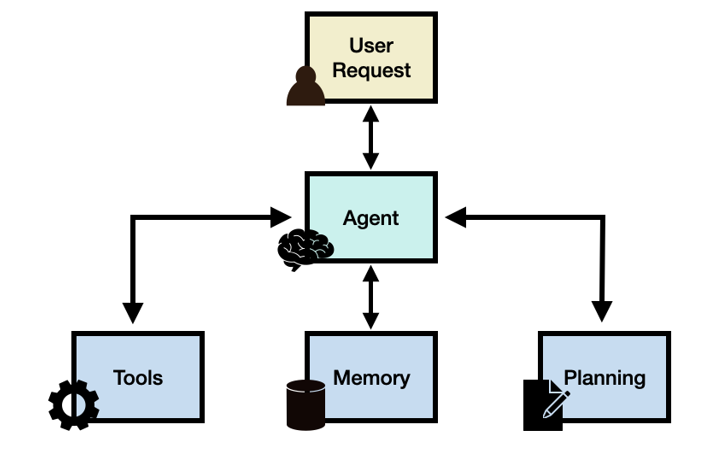

In [13]:
# Define tools
def get_tavily_search_retriever():
    retriever = TavilySearchAPIRetriever(k=7)
    retriever_description = "Use this tool when you need to answer questions related to current events and latest happenings or anything related to the user ask"
    retrieve_tool = create_retriever_tool(retriever=retriever, name="web_search", description=retriever_description)
    return retrieve_tool

# Creating a list of tools for LLM Math and Web Search
tavily_search_tool = get_tavily_search_retriever()
tools = load_tools(["llm-math"], llm=llm)
tools = tools + [tavily_search_tool]

In [15]:
# Initialize memory
memory = ConversationBufferMemory(memory_key="chat_history")

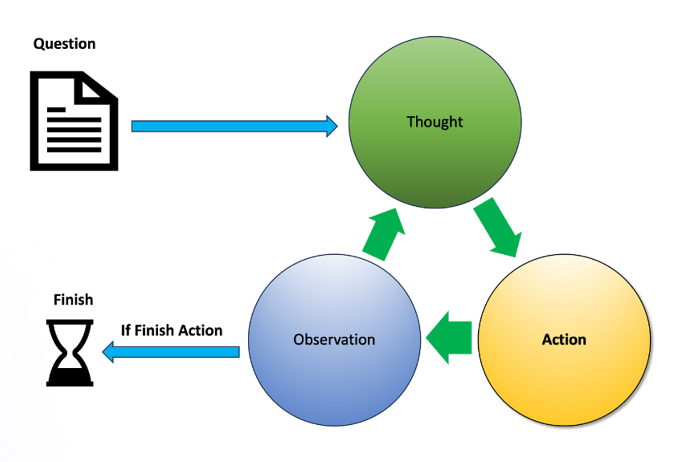

In [16]:
# Initialize the agent with verbose output
agent = initialize_agent(tools, llm, agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION, verbose=True, memory=memory)

In [20]:
agent.run(input="Which is hotter today? Hyderabad or Delhi?")



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: web_search
Action Input: Current temperature in Hyderabad, India. Current temperature in Delhi, India.
Observation: Current weather in Hyderabad, Telangana, India. Check current conditions in Hyderabad, Telangana, India with radar, hourly, and more.

Everything you need to know about today's weather in Hyderabad, Telangana, India. High/Low, Precipitation Chances, Sunrise/Sunset, and today's Temperature History.

Hyderabad, Telangana, India Weather Forecast, with current conditions, wind, air quality, and what to expect for the next 3 days.

Important Links
Join us in designing our new Home page
IMD's warnings through APIs and Social media
Our Services
Rainfall Information
Monsoon Information
Cyclone Information
Agromet Advisory Services
Climate Services
Urban Meteorological Services
Aviation Services
Climate Hazard & Vulnerability Atlas
Geospatial Services
Forecasts
Mumbai
Bengaluru
Chennai
Hyderabad


'The current temperature in Hyderabad is 25°C with light rain, while in Delhi it is 30°C. Therefore, Delhi is hotter today than Hyderabad.'

In [27]:
agent.run(input="In which year is the latest child of Elon Musk born?")



> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? Yes
Action: web_search
Action Input: Elon Musk latest child birth year
Observation: Elon Musk's 11 Children: All About His Kids and Their Mothers
Elon Musk is the father of 11 children, including a pair of twins and a set of triplets with his ex-wife Justine Wilson and two boys and a girl with ex-girlfriend Grimes
Elon Musk's family keeps on growing.
 The April 18 petition seeks the legal change of her name to Vivian Jenna Wilson (the maiden name of her mother, Justine Wilson); recognition of her gender as female; and the issuance of a new birth certificate to reflect the changes.
 The papers reveal that in April, Musk and Zilis — who is the project director at his Neuralink company — asked a Texan county court to change their babies' names so they would "have their father's last name and contain their mother's last name as part of their middle name. At the time, she also revealed that the couple wants more b

"The latest information available does not provide a specific year for the birth of Elon Musk's most recent child. The search results mention his children, including those with his ex-wife Justine Wilson and ex-girlfriend Grimes, but do not specify the birth year of the latest child. If you need the exact birth year, I would need to perform another search with a more specific query."